In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import datetime
from scipy.stats import skew
from scipy.stats import norm
import os



#Environment settings
data_path_in = 'Data/input/'
data_path_out= 'Data/ouput/'

# Loading datasets

In [4]:
# load dataframes 
train = pd.read_csv(data_path_in+'train.csv')
test = pd.read_csv(data_path_in+'test.csv')

print("Train set has shape {}.\nTest set has shape {}" .format(train.shape,test.shape) )

Train set has shape (523021, 36).
Test set has shape (45689, 34)


# Combining train & test data

In [5]:
# Dropping the 2 features not present in test set
train_stripped = train.copy()
train_stripped=train_stripped.drop(columns=['NumberOfCustomers','NumberOfSales'],axis=1)
all_data = pd.concat([train_stripped,test],axis=0).reset_index()

#to restore the original column order
all_data= all_data[list(test.columns.values)]
all_data.shape

(568710, 34)

# 1. Categorical features

In [6]:
cat_features = all_data.select_dtypes(exclude=[np.number])

print("There are {} numeric features ({:.2f}% of total) ".format(cat_features.shape[1],
                                                                 (cat_features.shape[1]/
                                                                  all_data.shape[1])*100))

There are 4 numeric features (11.76% of total) 


In [7]:
all_data.describe(exclude=[np.number])

,Date,StoreType,AssortmentType,Events
count,568710,568710,568710,428171
unique,790,4,3,21
top,20/08/2016,Hyper Market,General,Rain
freq,749,318206,322296,220716


## 1.1 Date manipulation
The Python datetime library provides several useful objects to manipulate times and dates

In [8]:
all_data.Date.head()

0    01/03/2016
1    02/03/2016
2    04/03/2016
3    05/03/2016
4    06/03/2016
Name: Date, dtype: object

In [9]:
all_data.Date=all_data.Date.apply(lambda x:datetime.datetime.strptime(x, '%d/%m/%Y'))
all_data.Date.head()

0   2016-03-01
1   2016-03-02
2   2016-03-04
3   2016-03-05
4   2016-03-06
Name: Date, dtype: datetime64[ns]

## 1.2 Missing Values
As seen by the describe function , the only categorical features with missing values is Events.

In [10]:
print ("There are {} missing values of Events({:.2f}%)".format(all_data['Events'].isna().sum(),
                                                                  all_data['Events'].isna().sum()/
                                                                  all_data.shape[0]*100))

There are 140539 missing values of Events(24.71%)


In [11]:
all_data['Events'].unique()

array(['Rain-Snow', 'Snow', 'Rain', nan, 'Fog-Rain', 'Fog-Rain-Snow',
       'Fog', 'Rain-Thunderstorm', 'Rain-Hail', 'Fog-Rain-Thunderstorm',
       'Fog-Rain-Hail-Thunderstorm', 'Rain-Snow-Hail',
       'Fog-Rain-Snow-Hail', 'Fog-Snow', 'Snow-Hail', 'Fog-Thunderstorm',
       'Thunderstorm', 'Fog-Snow-Hail', 'Rain-Snow-Hail-Thunderstorm',
       'Fog-Rain-Hail', 'Rain-Hail-Thunderstorm',
       'Rain-Snow-Thunderstorm'], dtype=object)

There are 21 unique events (nan included). All events seem to indicate bad weather condition. Let's check what the NaN values could be.

In [12]:
nan_index=all_data[all_data['Events'].isnull()].index.tolist()

print("Precipitation in mm of NaN Events {:.2f} with general mean {:.2f}"
      .format(all_data.loc[nan_index,'Precipitationmm'].mean(),
             all_data['Precipitationmm'].mean()))

print("Mean humidity of NaN Events {:.2f} with general mean {:.2f}"
      .format(all_data.loc[nan_index,'Mean_Humidity'].mean(),
             all_data['Mean_Humidity'].mean()))

print("Mean temperature in C of NaN Events {} with general mean {:.2f}"
      .format(all_data.loc[nan_index,'Mean_TemperatureC'].mean(),
             all_data['Mean_TemperatureC'].mean()))

print("CloudCover of NaN Events {:.2f} with general mean {:.2f}"
      .format(all_data.loc[nan_index,'CloudCover'].mean(),
             all_data['CloudCover'].mean()))

print("Mean visibility in km of NaN Events {:.2f} with general mean {:.2f}"
      .format(all_data.loc[nan_index,'Mean_VisibilityKm'].mean(),
             all_data['Mean_VisibilityKm'].mean()))

Precipitation in mm of NaN Events 0.01 with general mean 0.78
Mean humidity of NaN Events 64.38 with general mean 74.30
Mean temperature in C of NaN Events 10.979016500757798 with general mean 10.01
CloudCover of NaN Events 4.96 with general mean 5.56
Mean visibility in km of NaN Events 15.27 with general mean 12.25


As seen in the previous analysis ,NaN Events have generally less rain ,humidity and cloud cover.<br> The visibility is generally higher whereas the temperature more ore less within the dataset mean. <br>It's seems that NaN events correspond to Normal weather conditions.

In [13]:
all_data.Events = all_data.Events.fillna('Normal')
print ("There are {} missing values of Events left".format(all_data['Events'].isna().sum(),
                                                                  all_data['Events'].isna().sum()/
                                                                  all_data.shape[0]*100))

There are 0 missing values of Events left


# 2. Numerical features

In [14]:
numeric_features = all_data.select_dtypes(include=[np.number])

print("There are {} numeric features ({:.2f}% of total) ".format(numeric_features.shape[1],
                                                                 (numeric_features.shape[1]/
                                                                  all_data.shape[1])*100))


There are 30 numeric features (88.24% of total) 


In [15]:
all_data.describe()

,StoreID,IsHoliday,IsOpen,HasPromotions,NearestCompetitor,Region,Region_AreaKM2,Region_GDP,Region_PopulationK,CloudCover,...,Mean_TemperatureC,Mean_VisibilityKm,Mean_Wind_SpeedKm_h,Min_Dew_PointC,Min_Humidity,Min_Sea_Level_PressurehPa,Min_TemperatureC,Min_VisibilitykM,Precipitationmm,WindDirDegrees
count,568710.000000,568710.000000,568710.000000,568710.000000,568710.000000,568710.000000,568710.000000,568710.000000,568710.000000,519111.000000,...,568710.000000,554751.000000,568710.000000,568710.000000,568710.000000,568710.000000,568710.000000,554751.000000,568710.000000,568710.000000
mean,1373.957616,0.029964,0.829147,0.380157,7999.119534,5.700586,12448.404758,14057.774367,3867.832217,5.560682,...,10.011000,12.250188,11.784913,3.340256,50.406260,1012.401630,5.852888,7.290294,0.780502,171.945909
std,216.381498,0.170489,0.376381,0.485426,11529.083651,3.358435,9197.663508,2753.553082,2814.035417,1.717195,...,6.883573,5.017721,5.878919,5.895683,19.309611,8.925047,6.238434,4.929762,2.551008,102.741075
min,1000.000000,0.000000,0.000000,0.000000,47.000000,0.000000,344.000000,9893.000000,816.000000,0.000000,...,-13.000000,0.000000,2.000000,-18.000000,8.000000,970.000000,-15.000000,0.000000,0.000000,-1.000000
25%,1187.000000,0.000000,1.000000,0.000000,1057.000000,3.000000,7215.000000,11849.000000,1293.000000,5.000000,...,4.000000,10.000000,8.000000,-1.000000,35.000000,1007.000000,1.000000,3.000000,0.000000,75.000000
50%,1373.000000,0.000000,1.000000,0.000000,3321.000000,6.000000,9643.000000,15017.000000,2770.000000,6.000000,...,10.000000,11.000000,11.000000,3.000000,50.000000,1013.000000,6.000000,8.000000,0.000000,194.000000
75%,1561.000000,0.000000,1.000000,1.000000,9673.000000,9.000000,15566.000000,15931.000000,5727.000000,7.000000,...,16.000000,14.000000,14.000000,8.000000,65.000000,1018.000000,11.000000,10.000000,0.250000,254.000000
max,1748.000000,1.000000,1.000000,1.000000,85070.000000,10.000000,32221.000000,23931.000000,8146.000000,8.000000,...,30.000000,31.000000,53.000000,18.000000,100.000000,1038.000000,24.000000,31.000000,58.930000,360.000000


## 2.1 Numerical data correlation

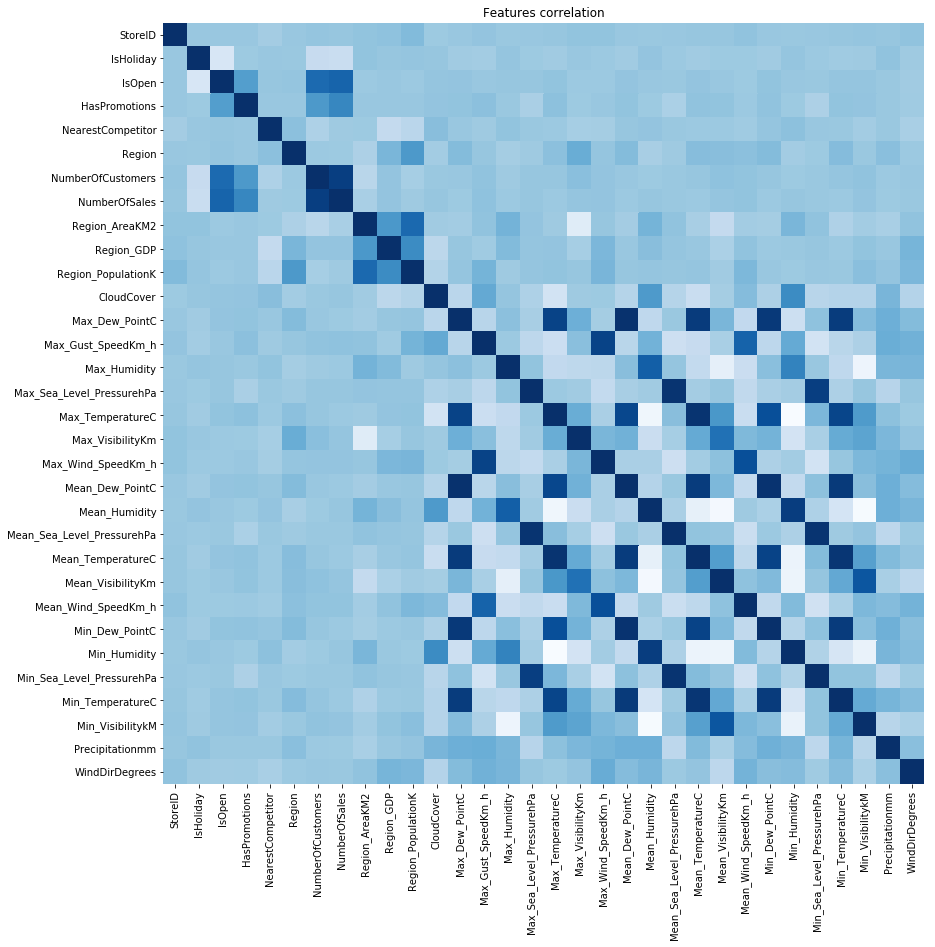

In [16]:
corrmat = train.corr()
plt.subplots(figsize=(14,14))
sns.heatmap(corrmat, square=True, annot=False,cbar=False,cmap="Blues") \
.set_title('Features correlation');

## 2.2 Numerical missing values

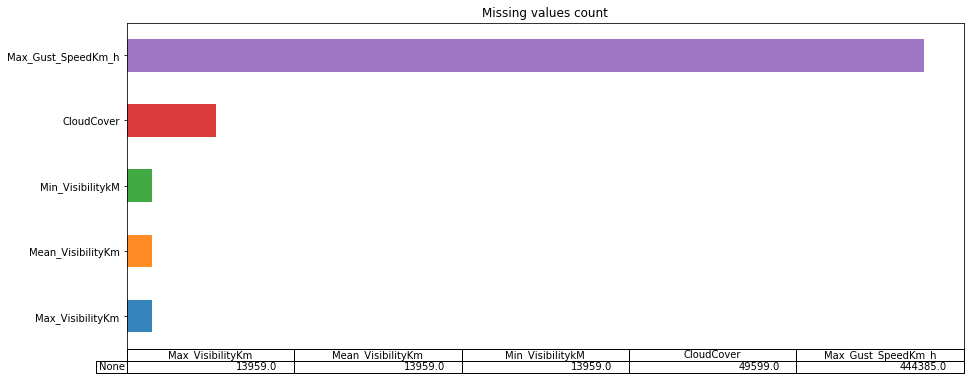

In [17]:
# Missing values# 
plt.figure(figsize=(15,6))
rows_length = numeric_features.shape[0]
numeric_nan_length = numeric_features.isna().sum().where(lambda x : x > 0).dropna()
numeric_nan_length = numeric_nan_length.sort_values()
ax = numeric_nan_length \
.plot(kind='barh', alpha=0.9, title='Missing values count', table=True)
ax.xaxis.set_visible(False) # hide x axis labels

### 2.2.1 Max_Gust_SpeedKm_h

In [18]:
all_data=all_data.drop('Max_Gust_SpeedKm_h',axis=1)
all_data.shape

(568710, 33)

### 2.2.2 Visibility
Since the Visibility has a high negative correlation  with Humidity, a good imputation method could be to group data by Humidity and use the median value to fill in missing values.<br>
Intuitively the minimum visibility corresponds to the maximum humidity and viceversa.<br>
Some humidity levels could not have visiblity values, so a good solution could be to take the mean between the two adiacent values

In [19]:
import math

min_vis_dict=all_data.groupby('Max_Humidity')['Min_VisibilitykM'].apply(lambda x: x.median()).to_dict()
max_vis_dict=all_data.groupby('Min_Humidity')['Max_VisibilityKm'].apply(lambda x: x.median()).to_dict()
mean_vis_dict=all_data.groupby('Mean_Humidity')['Mean_VisibilityKm'].apply(lambda x: x.median()).to_dict()

#Function that replaces missing values of the median with the mean of next and previous values
def replace_nan_median(visdict_list):
    for visdict in visdict_list:
        item_list=[visdict[x] for x in visdict.keys()]
        for val in range(len(item_list)):
            if(math.isnan(item_list[val])):
                prev_val = (val-1) < 0 and item_list[val+1]  or item_list[val-1]
                next_val = (val+1) > len(item_list) and item_list[val-1] or item_list[val+1]
                item_list[val] = float(int((prev_val + next_val)/2))
        iterator = 0
        for k,i in visdict.items():
            visdict[k]=item_list[iterator]
            iterator+=1

#Function that replaces nan in the dataframe with the dictionary
#value corresponding to the samples humidity level

def replace_nan_df(col_name1,col_name2,dictionary):
    nan_index=all_data[all_data[col_name1].isnull()].index.tolist()
    for index in tqdm(nan_index):
        humidty_lvl = all_data.loc[index,col_name2] 
        all_data.loc[index,col_name1] = dictionary[humidty_lvl]

    
        
replace_nan_median([min_vis_dict,max_vis_dict,mean_vis_dict])

#Replacing nan in dataframe 
replace_nan_df('Min_VisibilitykM','Max_Humidity',min_vis_dict)
replace_nan_df('Max_VisibilityKm','Min_Humidity',max_vis_dict)
replace_nan_df('Mean_VisibilityKm','Mean_Humidity',mean_vis_dict)

for col in ["Min_VisibilitykM","Max_VisibilityKm","Mean_VisibilityKm"]:
    print ("There are {} missing values of {} left".
           format(all_data[col].isna().sum(),col))
os.system('say "Visibility Done."')

100%|██████████| 13959/13959 [01:10<00:00, 196.93it/s]


There are 0 missing values of Min_VisibilitykM left
There are 0 missing values of Max_VisibilityKm left
There are 0 missing values of Mean_VisibilityKm left


0

In [20]:
#substitute with regression below
all_data['CloudCover'] = all_data['CloudCover'].fillna(all_data['CloudCover'].median())

# 3. Data Visualisation

In [56]:
all_data.groupby(['StoreType'])['HasPromotions'].count()
storeregions=all_data.groupby(['Region'])['StoreID'].unique()
total_stores=0;
store_dict = {}
for i in range(0,11):
    total_stores+=len(storeregions[i])
    store_dict[i]=len(storeregions[i])

print("Total stores {} ".format(total_stores))
for i,k in store_dict.items():
    print("Region {} has {} stores ({:.2f}% of total)".format(i,k, (k/total_stores)*100))

Total stores 749 
Region 0 has 55 stores (7.34% of total)
Region 1 has 24 stores (3.20% of total)
Region 2 has 125 stores (16.69% of total)
Region 3 has 92 stores (12.28% of total)
Region 4 has 18 stores (2.40% of total)
Region 5 has 51 stores (6.81% of total)
Region 6 has 36 stores (4.81% of total)
Region 7 has 62 stores (8.28% of total)
Region 8 has 28 stores (3.74% of total)
Region 9 has 169 stores (22.56% of total)
Region 10 has 89 stores (11.88% of total)


In [75]:
storenames=all_data['StoreType'].unique()
shopping_center=all_data[all_data['StoreType']== 'Shopping Center']
print(shopping_center['StoreID'].unique)
storetype = all_data.groupby(['StoreType'])['StoreID'].unique()
print(all_data.groupby(['StoreType'])['StoreID'])
for x in range(0,4):
    print("There are {} shops of type {}".format(len(storetype[x]),storenames[x]))

<bound method Series.unique of 89441     1129
89442     1129
89443     1129
89444     1129
89445     1129
89446     1129
89447     1129
89448     1129
89449     1129
89450     1129
89451     1129
89452     1129
89453     1129
89454     1129
89455     1129
89456     1129
89457     1129
89458     1129
89459     1129
89460     1129
89461     1129
89462     1129
89463     1129
89464     1129
89465     1129
89466     1129
89467     1129
89468     1129
89469     1129
89470     1129
          ... 
564288    1676
564289    1676
564290    1676
564291    1676
564292    1676
564293    1676
564294    1676
564295    1676
564296    1676
564297    1676
564298    1676
564299    1676
564300    1676
564301    1676
564302    1676
564303    1676
564304    1676
564305    1676
564306    1676
564307    1676
564308    1676
564309    1676
564310    1676
564311    1676
564312    1676
564313    1676
564314    1676
564315    1676
564316    1676
564317    1676
Name: StoreID, Length: 7110, dtype: int64>
There are 4

### 2.2.3 CloudCover

In [244]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score,KFold

rf =  RandomForestClassifier(n_estimators=50,verbose=True)

cloud_data = all_data.copy()
cloud_data = pd.get_dummies(cloud_data)
cloud_data['Date_delta'] = (cloud_data['Date'] - cloud_data['Date'].min())  / np.timedelta64(1,'D')
cloud_data=cloud_data.drop('Date',axis=1)
nan_indexes=cloud_data[cloud_data['CloudCover'].isnull()].index.tolist()
good_indexes =cloud_data[~cloud_data['CloudCover'].isnull()].index.tolist()

train_cloud = cloud_data.loc[good_indexes]
test_cloud = cloud_data.loc[nan_indexes]
print(train_cloud.shape)
print(test_cloud.shape)

X_train_cloud = train_cloud.copy()
X_train_cloud = X_train_cloud.drop(['CloudCover'], axis=1)
y_train_cloud = train_cloud['CloudCover']
test_cloud = test_cloud.drop('CloudCover',axis=1)

scaler = RobustScaler()
X_train_cloud = scaler.fit_transform(X_train_cloud)
test_cloud = scaler.transform(test_cloud)

# kf = KFold(5, shuffle=True, random_state=42).get_n_splits(X_train_cloud)
# score_CV= cross_val_score(rf, X_train_cloud, y_train_cloud, cv = kf)

# print("The 10-fold crossvalidation of RF is {:.5f} +/- {:.3f}".format(score_CV.mean(),score_CV.std()))
# os.system('say "Crossvalidation done."')

(519111, 59)
(49599, 59)


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   48.2s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   53.3s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   55.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   49.5s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   50.9s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished


The 10-fold crossvalidation of RF is 0.95911 +/- 0.082


0

In [252]:
# rf.fit(X_train_cloud,y_train_cloud)
# pred_results =rf.predict(test_cloud)
nan_index=cloud_data[cloud_data['CloudCover'].isnull()].index.tolist()
result_df = pd.DataFrame(data={' Index' : nan_index,
                               'CloudCover': pred_results})

,Index,CloudCover
0,5,8.0
1,6,8.0
2,7,8.0
3,17,8.0
4,112,8.0
5,137,8.0
6,140,8.0
7,144,6.0
8,145,1.0
9,156,8.0


# This part should be executed only for solution 3

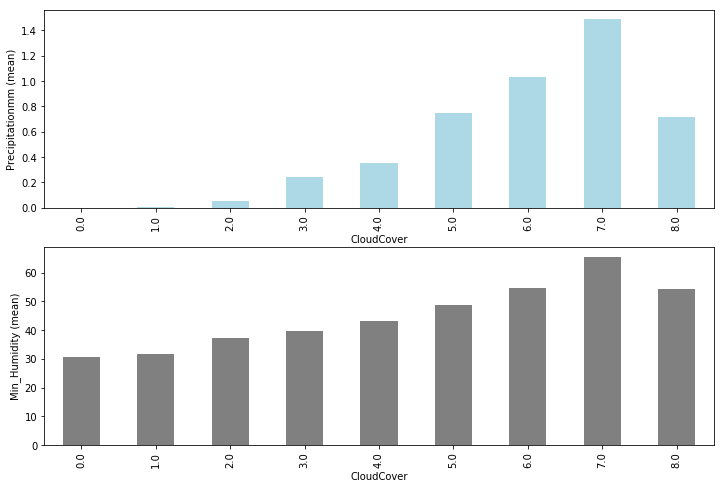

In [243]:
    #############
    # solution 3
    #############

    plt.figure(figsize=(12,8))
    plt.subplot2grid((2,1), (0,0))
    all_data.groupby(['CloudCover'])['Precipitationmm'].mean().plot(kind='bar',color='lightblue')
    plt.xlabel('CloudCover')
    plt.ylabel('Precipitationmm (mean)')
    plt.subplot2grid((2,1), (1,0))
    all_data.groupby(['CloudCover'])['Min_Humidity'].mean().plot(kind='bar',color='gray')
    plt.xlabel('CloudCover')
    plt.ylabel('Min_Humidity (mean)')
    plt.show()

As the CloudCover value rises also Precipitationmm and Min_Humidity increase. <br>Except for CloudCover value 8.0 which looks like an anomaly (values are very similar to CloudCover level 5.0).

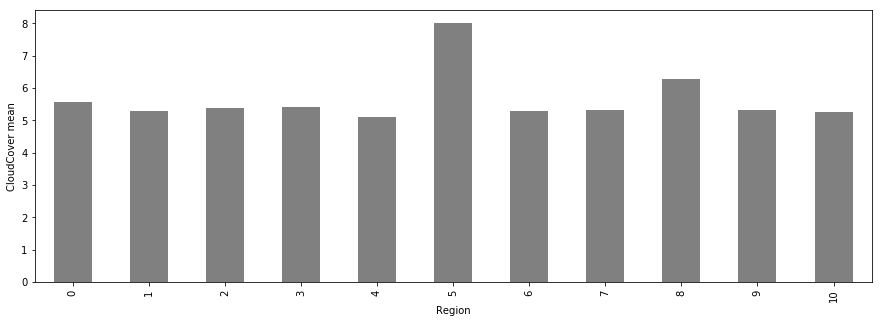

In [203]:
plt.figure(figsize=(15,5))
all_data.groupby(['Region'])['CloudCover'].mean().plot(kind='bar',color='gray')
plt.ylabel('CloudCover mean')
plt.show()

A clear outlier is Region 5 which has a mean CloudCover value of 8 ( which means that the lowest valueis 8). <br>A good imputation solution for region 5 is to set all CloudCover NaNs to 8.

In [154]:
index5=all_data[all_data['Region']==5].index.tolist()
all_data.loc[index5,'CloudCover']=8

Let's check which other regions have CloudCover value 8 in the dataset.

# SHIT SHIT SHIT